In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import backend

tf.config.run_functions_eagerly(True)

2022-10-03 09:42:27.196333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, brier_score_loss, log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras_unet_collection import utils as k_utils

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)

In [5]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead2.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead2.npy"))
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [6]:
filename_train = filename_neg_train+filename_pos_train

In [7]:
filename_valid = filename_neg_valid[4::50] + filename_pos_valid[4::50]

In [8]:
L_valid = len(filename_valid)
L_var = L_vars

TEST_input = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

In [9]:
input_shape = (64, 64, 15)

IN = layers.Input(shape=input_shape)

X = IN
model_name = 'encoder'
X = layers.Conv2D(64, kernel_size=2, strides=2, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm1".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down0_gelu1".format(model_name))(X)

X = layers.Conv2D(64, kernel_size=3, padding="same", name="{}_down0_conv".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm2".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down0_gelu2".format(model_name))(X)


X = layers.Conv2D(128, kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm1".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down1_gelu1".format(model_name))(X)

X = layers.Conv2D(128, kernel_size=3, padding="same", name="{}_down1_conv".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm2".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down1_gelu2".format(model_name))(X)


X = layers.Conv2D(256, kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm1".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down2_gelu1".format(model_name))(X)

X = layers.Conv2D(256, kernel_size=3, padding="same", name="{}_down2_conv".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm2".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down2_gelu2".format(model_name))(X)


X = layers.Conv2D(512, kernel_size=2, strides=2, name="{}_down3".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm1".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down3_gelu1".format(model_name))(X)

X = layers.Conv2D(512, kernel_size=3, padding="same", name="{}_down3_conv".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm2".format(model_name))(X)
X = layers.Activation("gelu", name="{}_down3_gelu2".format(model_name))(X)

L = layers.Flatten()(X)

L = layers.Dense(512)(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_dense_norm1".format(model_name))(L)
L = layers.Activation("gelu", name="{}_dense_gelu1".format(model_name))(L)

L = layers.Reshape((4, 4, 32))(L)

model_name = 'decoder'
L = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), padding='same', name='{}_up1_trans'.format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up1_norm1".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up1_gelu1".format(model_name))(L)

L = layers.Conv2D(256, kernel_size=3, padding="same", name="{}_up1_conv".format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up1_norm2".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up1_gelu2".format(model_name))(L)

L = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), padding='same', name='{}_up2_trans'.format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up2_norm1".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up2_gelu1".format(model_name))(L)

L = layers.Conv2D(128, kernel_size=3, padding="same", name="{}_up2_conv".format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up2_norm2".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up2_gelu2".format(model_name))(L)

L = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), padding='same', name='{}_up3_trans'.format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up3_norm1".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up3_gelu1".format(model_name))(L)

L = layers.Conv2D(64, kernel_size=3, padding="same", name="{}_up3_conv".format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up3_norm2".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up3_gelu2".format(model_name))(L)

L = layers.Conv2DTranspose(32, kernel_size=2, strides=(2, 2), padding='same', name='{}_up4_trans'.format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up4_norm1".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up4_gelu1".format(model_name))(L)

L = layers.Conv2D(32, kernel_size=3, padding="same", name="{}_up4_conv".format(model_name))(L)
L = layers.LayerNormalization(epsilon=1e-6, name="{}_up4_norm2".format(model_name))(L)
L = layers.Activation("gelu", name="{}_up4_gelu2".format(model_name))(L)

L = layers.Conv2D(15, kernel_size=1, padding="same", name="{}_up4_out".format(model_name))(L)


2022-10-03 09:46:01.542188: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-03 09:46:01.544150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-03 09:46:01.616686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-03 09:46:01.616771: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-03 09:46:01.770671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-03 09:46:01.770746: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [10]:
L

<KerasTensor: shape=(None, 64, 64, 15) dtype=float32 (created by layer 'decoder_up4_out')>

In [11]:
model = Model(inputs=IN, outputs=L, name='AE')

In [12]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'AE_Lead2'

model_name = '{}_pp15_tune'.format(key)
model_path = temp_dir+model_name

W_old = k_utils.dummy_loader(temp_dir+'AE_Lead2_pp15')
model.set_weights(W_old)

In [13]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-4))

In [14]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [15]:
X_batch = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch[...] = np.nan
Y_batch[...] = np.nan

In [16]:
Y_pred = model.predict([TEST_input])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2022-10-03 09:46:10.634947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-03 09:46:10.635666: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-10-03 09:46:10.953200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-10-03 09:46:14.693576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [17]:
def verif_metric(VALID_target, Y_pred):
    return np.mean(np.abs(VALID_target-Y_pred))

In [18]:
record = verif_metric(TEST_input, Y_pred)
print("Initial record: {}".format(record))

Initial record: 0.12071660907851908


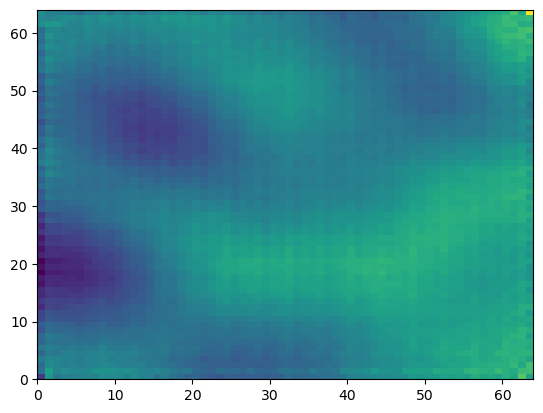

In [36]:
plt.pcolormesh(Y_pred[0, ..., 14])

tf.config.list_physical_devices('GPU')

In [ ]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(2, 14))
        N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(10, 25))
        #N_aug = int(np.random.uniform(20, 45))
        #N_aug = int(np.random.uniform(35, 50))
        
        N_storm = 100 - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            
            for l, c in enumerate(ind_pick_from_batch):
            
                X_batch[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [X_batch]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    #Y_pred = Y_pred_list[0]
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_input, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.4425114963317273 to 0.43008654726177886
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 182.8050684928894 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.43008654726177886 to 0.41797117355031826
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 185.20995020866394 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.41797117355031826 to 0.4023372836897901
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 190.4381546974182 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.4023372836897901 to 0.38641873616589684
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 183.331374168396 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.38641873616589684 to 0.3739658565332311
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 176.99525427818298 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3739658565332311 to 0.3645483934064358
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 198.32334065437317 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3645483934064358 to 0.3546238944603552
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 186.62869453430176 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3546238944603552 to 0.3479135507578465
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 194.1501224040985 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3479135507578465 to 0.340499703735933
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 183.7177095413208 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.340499703735933 to 0.3342185508834527
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 195.60409498214722 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3342185508834527 to 0.32806694651091706
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 181.96609950065613 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.32806694651091706 to 0.3223232524659642
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 188.6627414226532 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3223232524659642 to 0.3181987607904766
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 178.55444884300232 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.3181987607904766 to 0.31437821626731355
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 190.49674487113953 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.31437821626731355 to 0.31150417516899637
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 180.9112594127655 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.31150417516899637 to 0.30805155641356013
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 186.4853174686432 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.30805155641356013 to 0.30643810610980887
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 184.7639398574829 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.30643810610980887 to 0.304245567438556
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 183.50398540496826 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.304245567438556 to 0.30195931328541814
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 185.89882135391235 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.30195931328541814 to 0.2989776070221179
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 191.76101422309875 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2989776070221179 to 0.29366998289309254
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 181.516934633255 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.29366998289309254 to 0.28874914732020734
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 190.1495201587677 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.28874914732020734 to 0.2859744064219275
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 179.14935660362244 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2859744064219275 to 0.2818781660705419
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 181.82268023490906 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2818781660705419 to 0.278876655457689
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 184.1720633506775 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.278876655457689 to 0.2766101161399085
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 175.04725694656372 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2766101161399085 to 0.27293295845214594
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 177.82107591629028 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.27293295845214594 to 0.26956594481004154
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 180.5506865978241 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.26956594481004154 to 0.2685218383795448
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 172.8508746623993 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2685218383795448 to 0.2628011904813564
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 184.73026704788208 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2628011904813564 to 0.2601177275883999
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.48631381988525 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2601177275883999 to 0.25349910684209304
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 193.18052124977112 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.25349910684209304 to 0.2488200916383923
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.0066044330597 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2488200916383923 to 0.2476407282235849
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 177.28523421287537 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2476407282235849 to 0.24378092745694824
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 179.6928424835205 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.24378092745694824 to 0.24021533700188114
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 180.05253720283508 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.24021533700188114 to 0.2385110165847242
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.1526210308075 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2385110165847242 to 0.23483318394839484
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 184.4293339252472 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.23483318394839484 to 0.2307504791981377
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 200.36658811569214 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2307504791981377 to 0.2270592565709925
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 178.8514199256897 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2270592565709925 to 0.22368218577572885
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 172.33446383476257 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.22368218577572885 to 0.21651969812068672
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 171.17415690422058 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.21651969812068672 to 0.21236603648092314
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 170.57369089126587 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.21236603648092314 to 0.20798423102326863
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 176.94442296028137 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.20798423102326863 to 0.2064714219141254
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.43678212165833 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.2064714219141254 to 0.20351981151277265
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 171.55388021469116 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.20399281893776994 NOT improved
Validation loss improved from 0.20351981151277265 to 0.19937166810064516
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 179.5963532924652 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.19937166810064516 to 0.19745251788438323
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 168.51404118537903 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.19745251788438323 to 0.19528832041974034
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 177.29377913475037 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.19750117239086906 NOT improved
Validation loss improved from 0.19528832041974034 to 0.19430301613763215
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 182.59116101264954 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.19430301613763215 to 0.1913697643603055
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.03635692596436 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1913697643603055 to 0.19047866364918553
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.647536277771 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.19047866364918553 to 0.1890787786556548
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 177.64358472824097 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.1892297889957767 NOT improved
Validation loss improved from 0.1890787786556548 to 0.18638265773125748
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 175.61507725715637 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.18638265773125748 to 0.1852784149659309
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.27009272575378 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1852784149659309 to 0.184475623520186
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.53834176063538 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.184475623520186 to 0.18418297555998694
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.36546921730042 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.18418297555998694 to 0.18027679181030343
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.4286332130432 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.18064849778011755 NOT improved
Validation loss 0.1820832255294845 NOT improved
Validation loss improved from 0.18027679181030343 to 0.1754707590063097
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 182.75561213493347 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1754707590063097 to 0.17510568746311705
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 172.22736239433289 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.17510568746311705 to 0.17427687149544316
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 177.04571723937988 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.17427687149544316 to 0.1717513986179699
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 171.8465027809143 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1717513986179699 to 0.16990717472082364
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 181.50635981559753 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.16990717472082364 to 0.16882610993050692
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.80001378059387 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.16882610993050692 to 0.16714615632253452
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 170.95500874519348 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.16783937901163046 NOT improved
Validation loss 0.1685208316401556 NOT improved
Validation loss 0.17147822830429063 NOT improved
Validation loss 0.1674906893794308 NOT improved
Validation loss improved from 0.16714615632253452 to 0.16346096568687515
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 176.59396505355835 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.16346096568687515 to 0.16287021195230142
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 175.24695086479187 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.16366910576078333 NOT improved
Validation loss improved from 0.16287021195230142 to 0.1613334350156117
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 182.2810139656067 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.16385943001638326 NOT improved
Validation loss 0.16181353903446394 NOT improved
Validation loss 0.16231512774511025 NOT improved
Validation loss improved from 0.1613334350156117 to 0.15970853867172435
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 182.93148255348206 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.16251422148220607 NOT improved
Validation loss 0.1618156479467352 NOT improved
Validation loss improved from 0.15970853867172435 to 0.1581348926955972
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 176.7892062664032 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1581348926955972 to 0.15726489511888547
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.08207941055298 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.15726489511888547 to 0.1566051525021567
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 168.53607153892517 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1566051525021567 to 0.156273814693566
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 172.70222783088684 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.15760710137250633 NOT improved
Validation loss improved from 0.156273814693566 to 0.15356425691709844
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 181.7536678314209 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.15356425691709844 to 0.15242813258186783
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 165.35267639160156 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.15242813258186783 to 0.14942654111061607
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 169.9937388896942 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.14942654111061607 to 0.1477607039940627
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.75481152534485 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1477607039940627 to 0.14698448125182953
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 182.9956591129303 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.14727823586251454 NOT improved
Validation loss 0.14706595872084713 NOT improved
Validation loss improved from 0.14698448125182953 to 0.14587301432480235
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 178.7993893623352 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.1501298451445444 NOT improved
Validation loss improved from 0.14587301432480235 to 0.1450819446893198
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 169.06661987304688 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1450819446893198 to 0.14396957135570754
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.0053951740265 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.14396957135570754 to 0.1429617463383147
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.58443474769592 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.14799070281522428 NOT improved
Validation loss 0.14475601269849606 NOT improved
Validation loss 0.1436337485979644 NOT improved
Validation loss 0.14319630098974118 NOT improved
Validation loss 0.14339591213505876 NOT improved
Validation loss improved from 0.1429617463383147 to 0.14243568201006876
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.96626138687134 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.14243568201006876 to 0.14195148804930965
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.19943118095398 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.14195148804930965 to 0.14166160910658357
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 171.58807706832886 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.14166160910658357 to 0.14053748142903374
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 175.74956846237183 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.14161932920533496 NOT improved
Validation loss 0.1419966056082728 NOT improved
Validation loss 0.14465509932069057 NOT improved
Validation loss improved from 0.14053748142903374 to 0.14013670533804015
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.82191133499146 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.140594438441939 NOT improved
Validation loss 0.14104574468364914 NOT improved
Validation loss improved from 0.14013670533804015 to 0.1396339405297063
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.90309286117554 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.1396339405297063 to 0.13901870711465225
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 169.8879611492157 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss improved from 0.13901870711465225 to 0.13862260583925307
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 170.1526710987091 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.13862383608674583 NOT improved
Validation loss 0.1439010855980571 NOT improved
Validation loss 0.1387476262943189 NOT improved
Validation loss 0.13951955722238843 NOT improved
Validation loss 0.13890596740620414 NOT improved
Validation loss improved from 0.13862260583925307 to 0.13772139834159847
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 173.78403973579407 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.1377231856866067 NOT improved
Validation loss 0.14100599080566129 NOT improved
Validation loss 0.13931801231845364 NOT improved
Validation loss 0.1378252988534544 NOT improved
Validation loss 0.1384535776879901 NOT improved
Validation loss 0.13906179453290526 NOT improved
Validation loss improved from 0.13772139834159847 to 0.13635051722620004
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 174.56581354141235 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.13881173297285124 NOT improved
Validation loss 0.13781103059748137 NOT improved
Validation loss improved from 0.13635051722620004 to 0.13619052817424337
save to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/AE_Lead2_pp15/assets
--- 172.29002737998962 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Validation loss 0.13770109056125487 NOT improved
Validation loss 0.13752344012402454 NOT improved
Validation loss 0.13782408774149252 NOT improved
